In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from statsmodels.graphics.gofplots import qqplot
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial

## Задача 1. Пожертвования на благотворительность

Благотворительная организация разослала письма с предложением сделать пожертвование и получила отклик с пожертвованиями от некоторых адресатов. Организация хочет повысить общий объём пожертвований, посредством более эффективной рассылки. При этом организация не может рассылать письма всем подряд, т.к. в таком случае её письма приравняют к спаму, а самой организации будет нанесён огромный репутационный ущерб.  У организации имеются данные для каждого адресата:
- индикатор ответа на предыдущее письмо (`resplast`)
- число недель, прошедших с момента предыдущего пожертвования (`weekslast`)
- размеры текущего, предыдущего и среднего по всем предыдущим пожертвованиям в некоторых у.е. (`gift`, `giftlast`, `avggift`)
- число писем, отправляемых адресату в год (`mailsyear`)
- доля писем, в ответ на которые приходят пожертвования (`proresp`)

Перед тем как применять различные алгоритмы улучшения качества встаёт вопрос:  
**Какие признаки отличают людей, совершающих пожертвования?**

In [2]:
data = pd.read_csv("charity.csv", sep=';', decimal=',')

## Зрительный анализ

Для начала выполним зрительный анализ приведённых данных. Построим для признаков клиента и его отклика гистограммы и попарные графики.

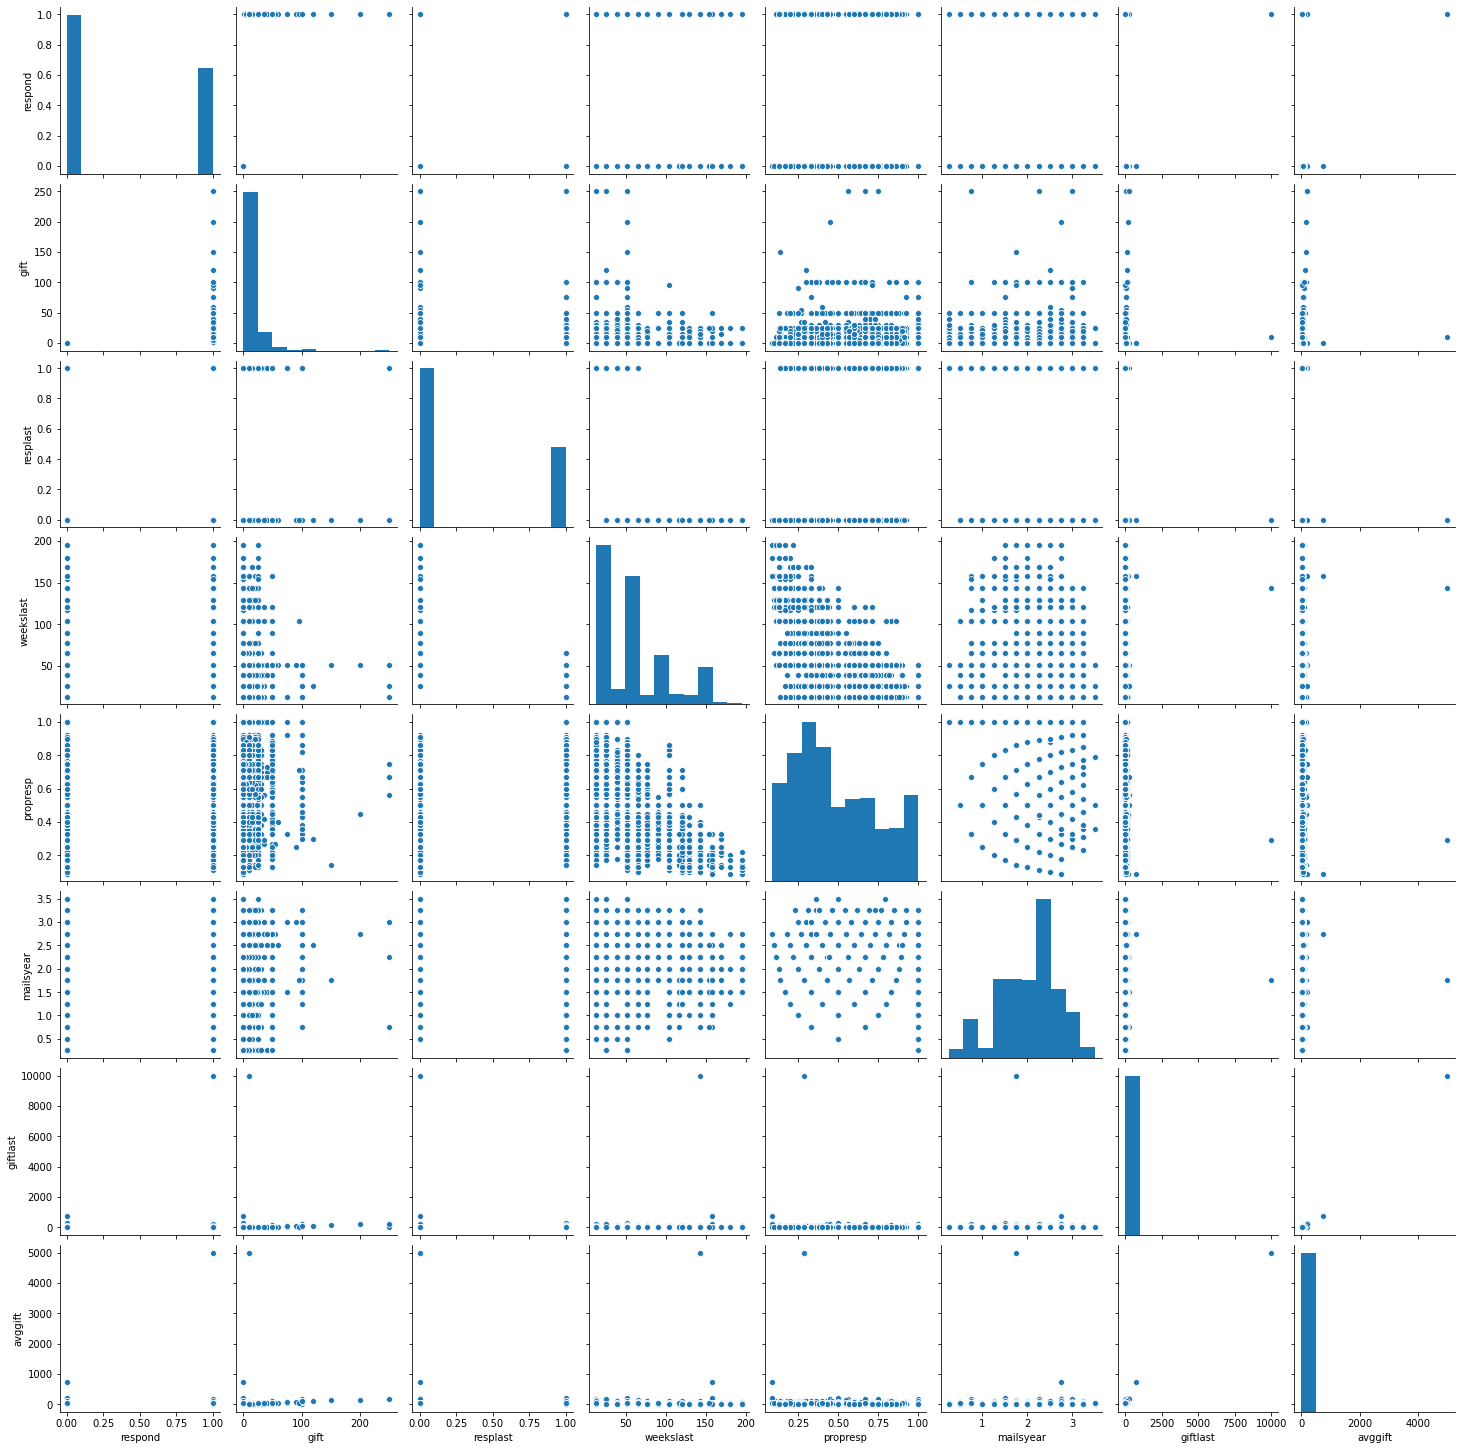

In [3]:
sns.pairplot(data)
plt.show()

### Анализ признаков `giftlast` и `avggift`

Гистограммы `giftlast` и `avggift` сосредоточены в одном столбце. Это говорит о том, что необходимо сделать преобразование над признаком, либо о наличии выбросов. Рассмотрим эти признаки подробнее.

In [4]:
data[['giftlast', 'avggift']].describe()

,giftlast,avggift
count,4268.000000,4268.000000
mean,19.748360,18.242851
std,154.200909,78.702860
min,1.000000,1.000000
25%,10.000000,10.000000
50%,10.000000,10.000000
75%,25.000000,23.330000
max,10000.000000,5005.000000


Построим диаграмму размаха для этих признаков

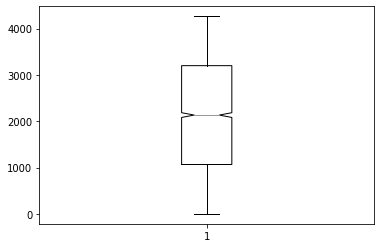

In [5]:
result = plt.boxplot(data[['giftlast', 'avggift']].T, notch=True)
plt.show()

Уберём верхние выбросы

In [6]:
giftlast_high_outlier = result['whiskers'][1].get_data()[1][1]
avggift_high_outlier = result['whiskers'][3].get_data()[1][1]
r_data = data[(data['giftlast'] <= giftlast_high_outlier) & (data['avggift'] <= avggift_high_outlier)].reset_index(drop=True)
r_data

IndexError: list index out of range

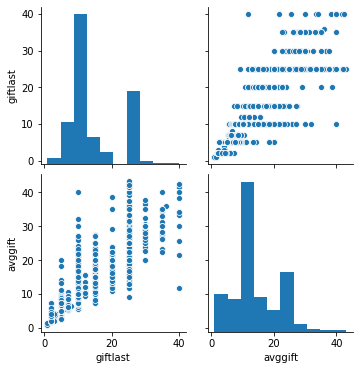

In [7]:
sns.pairplot(r_data[['giftlast', 'avggift']])
plt.show()

Гистограммы стали намного лучше, тем не менее очень не похоже, что они являются нормальными.

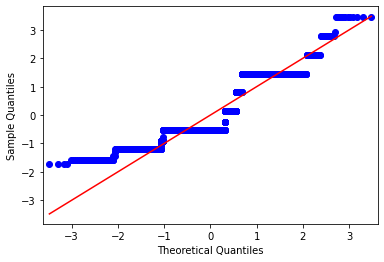

In [8]:
qqplot(r_data['giftlast'], fit=True, line='s')
plt.show()

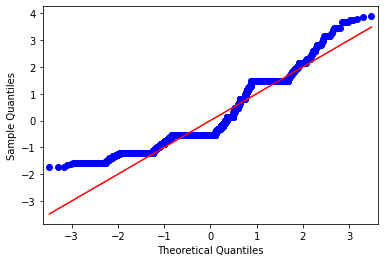

In [9]:
qqplot(r_data['avggift'], fit=True, line='s')
plt.show()

Посмотрим на лучшую $\lambda$ в преобразовании Бокса-Кокса с её $95\%$-ым доверительным интервалом

In [10]:
print(scipy.stats.boxcox(data['giftlast'], alpha=0.05)[1:])
print(scipy.stats.boxcox(data['avggift'], alpha=0.05)[1:])

(-0.14134950314804393, (-0.16917609707828293, -0.11380839626715258))
(-0.14989079841383143, (-0.17950533138709937, -0.12051456546913657))


Сделаем то же самое с данными без выбросов

In [11]:
print(scipy.stats.boxcox(r_data['giftlast'], alpha=0.05)[1:])
print(scipy.stats.boxcox(r_data['avggift'], alpha=0.05)[1:])

(0.23710753020373537, (0.19129408174841056, 0.28351968969405594))
(0.19710666966732304, (0.15083821379781226, 0.24391872697144448))


Можем выделить достаточно важную вещь, переход через 0. Поэтому воспользуемся преобразованием Бокса-Кокса при $\lambda=0$, то есть просто прологарифмируем данные

In [12]:
data['ln_giftlast'] = np.log(data['giftlast'])
data['ln_avggift'] = np.log(data['avggift'])

Опять построим диаграммы размаха

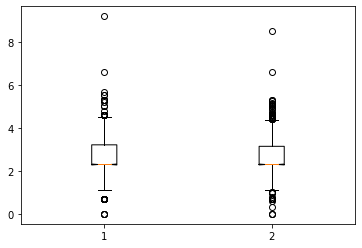

In [13]:
result = plt.boxplot(data[['ln_giftlast', 'ln_avggift']].T, notch=True)
plt.show()

In [14]:
giftlast_high_outlier = result['whiskers'][1].get_data()[1][1]
avggift_high_outlier = result['whiskers'][3].get_data()[1][1]
r_data = data[(data['ln_giftlast'] <= giftlast_high_outlier) & (data['ln_avggift'] <= avggift_high_outlier)].reset_index(drop=True)
r_data

,respond,gift,resplast,weekslast,propresp,mailsyear,giftlast,avggift,ln_giftlast,ln_avggift
0,0,0,0,143.00,0.30,2.50,10,10.0,2.302585,2.302585
1,0,0,0,65.43,0.30,2.50,10,10.0,2.302585,2.302585
2,0,0,1,13.14,0.30,2.50,10,10.0,2.302585,2.302585
3,0,0,0,120.14,0.30,2.50,10,10.0,2.302585,2.302585
4,1,10,0,103.86,0.20,2.50,10,10.0,2.302585,2.302585
...,...,...,...,...,...,...,...,...,...,...
4191,1,10,1,13.14,1.00,0.75,10,15.0,2.302585,2.708050
4192,1,25,1,13.14,0.67,0.75,25,25.0,3.218876,3.218876
4193,1,25,0,51.29,0.33,0.75,25,25.0,3.218876,3.218876
4194,0,0,0,51.29,0.33,0.75,50,50.0,3.912023,3.912023


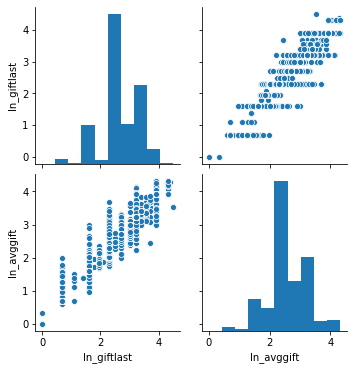

In [15]:
sns.pairplot(r_data[['ln_giftlast', 'ln_avggift']])
plt.show()

ShapiroResult(statistic=0.9079272747039795, pvalue=8.407790785948902e-45)


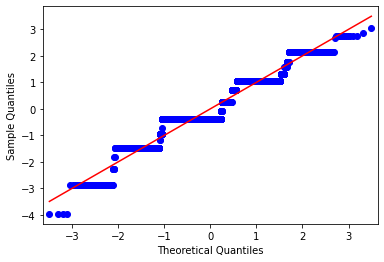

In [16]:
print(scipy.stats.shapiro(r_data['ln_giftlast']))
qqplot(r_data['ln_giftlast'], fit=True, line='s')
plt.show()

ShapiroResult(statistic=0.9516927003860474, pvalue=3.979308099796015e-35)


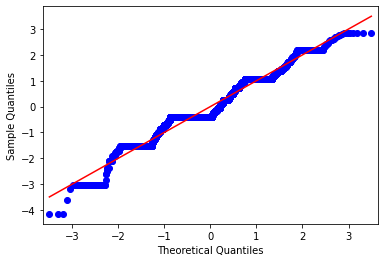

In [17]:
print(scipy.stats.shapiro(r_data['ln_avggift']))
qqplot(r_data['ln_avggift'], fit=True, line='s')
plt.show()

Гистограммы теперь больше напоминают нормальные, также видна зависимость признаков `ln_giftlast` и `ln_avggift` (натуральных логарифмов от соответствующих переменных). Отметим, что статистические тесты показали, что на самом деле распределения не нормальные, что является достаточно логичным, т.к. данных слишком много и они почти никогда в реальной жизни не распределены нормально. Тем не менее, будем теперь работать именно с такими данными.

In [18]:
data = r_data.drop(columns=['giftlast', 'avggift'])

### Анализ категорильного признака `resplast`

Также проанализируем таблицы сопряжённости с единственным категориальным признаком `resplast`

In [19]:
crosstab = pd.crosstab(data['respond'], data['resplast'])
crosstab

resplast,0,1
respond,,
0,2001,521
1,792,882


Отнормированная таблица сопряжённости

In [20]:
crosstab / len(data)

resplast,0,1
respond,,
0,0.476883,0.124166
1,0.188751,0.210200


Вероятности `respond` при фиксированном `resplast`

In [21]:
crosstab / crosstab.sum(axis=0).values[np.newaxis, :]

resplast,0,1
respond,,
0,0.716434,0.371347
1,0.283566,0.628653


In [22]:
print(scipy.stats.spearmanr(data['respond'], data['resplast']))
print(scipy.stats.kendalltau(data['respond'], data['resplast']))

SpearmanrResult(correlation=0.3324623105377175, pvalue=7.855222000099689e-109)
KendalltauResult(correlation=0.3324623105377176, pvalue=7.610781442731127e-103)


Видно, что данный признак (`resplast`) достаточно значим, т.к. $P(respond = 0 | resplast = 0) \approx 71.6\%$ и $P(respond = 1 | resplast = 1) \approx 62.9\%$, что подтверждается умеренным значением корреляции Спирмана и Кендалла (оба примерно равны $0.33$) и крайне низким p значением.

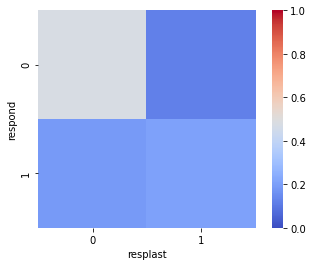

In [23]:
sns.heatmap(crosstab / len(data), vmin=0, vmax=1, square=True, cmap="coolwarm")
plt.show()

Гистограммы остальных признаков не кажутся очень привлекательными и не похожи на нормальное распределение

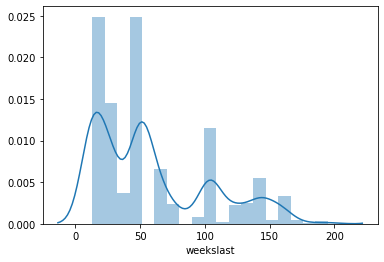

In [24]:
sns.distplot(data['weekslast'])
plt.show()

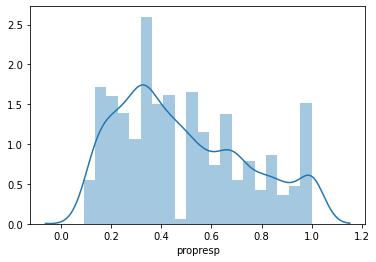

In [25]:
sns.distplot(data['propresp'])
plt.show()

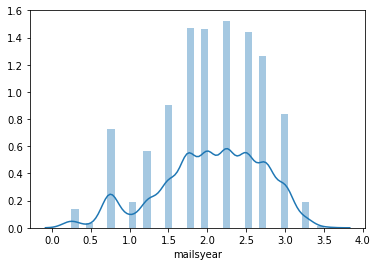

In [26]:
sns.distplot(data['mailsyear'])
plt.show()

## Логистическая регрессия и отбор признаков

Для начала построим логистическую регрессию по всем признакам

In [27]:
X = data.drop(columns=['gift', 'respond'])
y = data['respond']

In [28]:
model = LogisticRegression(penalty='none').fit(X, y)
y_pred = model.predict_proba(X)[:, 1]
print(f"ROC AUC: {roc_auc_score(y, y_pred)}")
print(f"Accuracy: {accuracy_score(y, y_pred >= 0.5)}")         

ROC AUC: 0.7723770366770034
Accuracy: 0.7128217349857007


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

In [30]:
model = LogisticRegression(penalty='none').fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")         

ROC AUC: 0.7597584979937922
Accuracy: 0.7054337464251669


Попробуем уменьшить количество признаков

In [31]:
columns = ['resplast', 'ln_giftlast', 'weekslast', 'mailsyear', 'propresp']
model = LogisticRegression(penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")         

ROC AUC: 0.7600537512302218
Accuracy: 0.7063870352716873


In [32]:
columns = ['resplast', 'weekslast', 'mailsyear', 'propresp']
model = LogisticRegression(penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.7601956999015823
Accuracy: 0.7035271687321258


In [33]:
columns = ['resplast', 'propresp']
model = LogisticRegression(penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.7536301006889242
Accuracy: 0.7054337464251669


In [34]:
columns = ['resplast']
model = LogisticRegression(penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.662137557725793
Accuracy: 0.6882745471877979


In [35]:
columns = ['propresp']
model = LogisticRegression(penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.7491369520781285
Accuracy: 0.7006673021925643


In [36]:
columns = ['propresp', 'mailsyear']
model = LogisticRegression(penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.7562343856461504
Accuracy: 0.7130600571973308


Видно, что максимум ROC-AUC и accuracy достигается на признаках `propresp` и `mailsyear`. Давайте изучим признак `mailsyear` немного подробнее:

count    4196.000000
mean        2.046771
std         0.666857
min         0.250000
25%         1.750000
50%         2.000000
75%         2.500000
max         3.500000
Name: mailsyear, dtype: float64


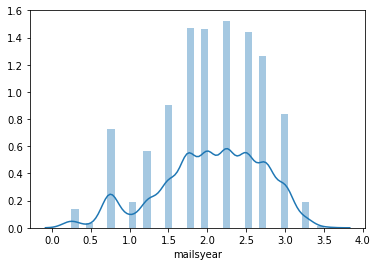

In [37]:
print(data['mailsyear'].describe())
sns.distplot(data['mailsyear'])
plt.show()

Посмотрим все возможные значения признака:

In [38]:
sorted(data['mailsyear'].unique())

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5]

Попробуем сделать признак бинарным: 0, если $mailsyear \leq 1$ и 1, иначе.

In [39]:
data['mailsyear_bin'] = data['mailsyear'] <= 1

In [40]:
X = data.drop(columns=['gift', 'respond'])
y = data['respond']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

In [41]:
columns = ['propresp', 'mailsyear_bin']
model = LogisticRegression(penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.7545177530471647
Accuracy: 0.7111534795042898


Результат не особо хороший. Всевозможных значений признака `mailsyear` не очень много, давайте попробуем считать данный признак категориальным.

In [42]:
column = 'mailsyear'
data = data.join(pd.get_dummies(data[column], prefix=column, drop_first=True))

In [43]:
X = data.drop(columns=['gift', 'respond'])
y = data['respond']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

In [44]:
columns = ['propresp']
columns.extend(list(filter(lambda x: x.startswith(column + "_") and x != 'mailsyear_bin', X.columns)))
print("All columns:")
print("\t".join(map(str, columns)))

All columns:
propresp	mailsyear_0.5	mailsyear_0.75	mailsyear_1.0	mailsyear_1.25	mailsyear_1.5	mailsyear_1.75	mailsyear_2.0	mailsyear_2.25	mailsyear_2.5	mailsyear_2.75	mailsyear_3.0	mailsyear_3.25	mailsyear_3.5


In [45]:
model = LogisticRegression(penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.751517904459081
Accuracy: 0.7130600571973308


Хотя добавление признака `mailsyear` не очень сильно увеличивает ROC-AUC и точность предсказаний модели наши эксперименты показывают, что, сделав различные преобразования с данным признаком, это маленькое увеличение остаётся. Отсюда мы делаем вывод о существенности признака `mailsyear`.

Видно, что существенными признаками являются `propresp` (доля писем, в ответ на которые приходят пожертвования) и в меньшей степени `mailsyear` (число писем, отправляемых адресатам в год). Взглянем на гистограммы признаков при известных ответах на них:

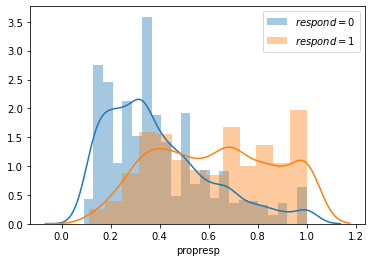

In [46]:
sns.distplot(data[data['respond'] == 0]['propresp'], label='$respond = 0$')
sns.distplot(data[data['respond'] == 1]['propresp'], label='$respond = 1$')
plt.legend()
plt.show()

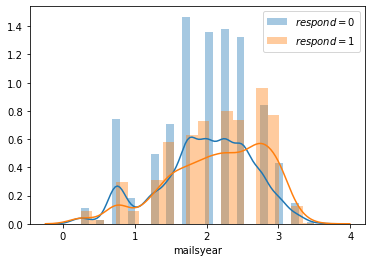

In [47]:
sns.distplot(data[data['respond'] == 0]['mailsyear'], label='$respond = 0$')
sns.distplot(data[data['respond'] == 1]['mailsyear'], label='$respond = 1$')
plt.legend()
plt.show()

In [48]:
scipy.stats.mannwhitneyu(data[data['respond'] == 0]['mailsyear'], data[data['respond'] == 1]['mailsyear'])

MannwhitneyuResult(statistic=1791560.5, pvalue=2.952062012687692e-17)

In [49]:
scipy.stats.mannwhitneyu(data[data['respond'] == 0]['ln_giftlast'], data[data['respond'] == 1]['ln_giftlast'])

MannwhitneyuResult(statistic=2033871.0, pvalue=0.017213022288110683)

In [50]:
from sklearn.feature_selection import f_classif

<BarContainer object of 4 artists>

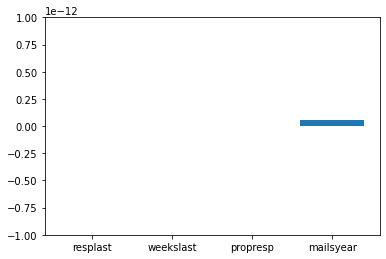

In [51]:
plt.bar(X.iloc[:, :4].columns, f_classif(X.iloc[:, :4], y)[1] * 6)

Распределения действительно очень сильно отличаются в случае `propresp` и немного отличаются для `mailsyear`, чего нельзя наблюдать для других признаков (например, для `ln_giftlast`)

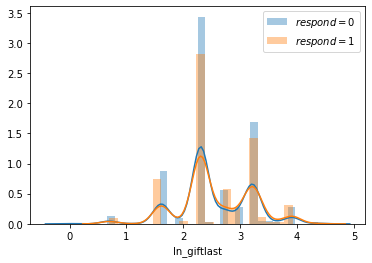

In [52]:
sns.distplot(data[data['respond'] == 0]['ln_giftlast'], label='$respond = 0$')
sns.distplot(data[data['respond'] == 1]['ln_giftlast'], label='$respond = 1$')
plt.legend()
plt.show()

## Выводы

Единственный значимый признак для определения людей, которые совершат пожертвования - доля писем, в ответ на которые человек присылает пожертвование.

## Задача 2. Платёж по кредиту

Платеж по кредиту. Для 30000 клиентов тайваньского банка известны сумма кредита, демографические показатели и история платежей по кредитам за последние пять месяцев (факт просрочки, сумма необходимой выплаты, сумма платежа).

Задача. **Построить модель, предсказывающую вероятность просрочки следующего платежа, оценить вклад факторов**

In [53]:
data = pd.read_csv("default.csv", sep=';', decimal=',')
data.drop(columns=['ID'], inplace=True)
data['SEX'] -= 1

## Зрительный анализ данных

Рассмотрим категориальные признаки `SEX`, `EDUCATION`, `MARRIAGE`

In [54]:
print(data['SEX'].unique())

[1 0]


Полов всего два, просто оставляем бинарный признак

Рассмотрим образование:

In [55]:
print(data['EDUCATION'].unique())

[2 1 3 5 4 6 0]


Целых 7 вариантов. При этом в исходной табличке говорилось, что возможны только лишь 4 варианта. Значит полагаться на описание данных мы сильно не можем. В будущем сделаем OneHotEncoding данного признака 6 колонками.

In [56]:
print(data['MARRIAGE'].unique())

[1 2 3 0]


Всего 4 варианта, поэтому будем делать OneHotEncoding 3 колонками.

В данных присутствуют и другие категориальные признаки, но мы не будем их трогать пока что.

### Преобразование категориальных признаков

In [57]:
for column in ['EDUCATION', 'MARRIAGE']:
    data = data.join(pd.get_dummies(data[column], prefix=column, drop_first=True))
    data.drop(columns=column, inplace=True)

## Анализ непрерывных признаков

Начнём с анализа возраста (колонка `AGE`)

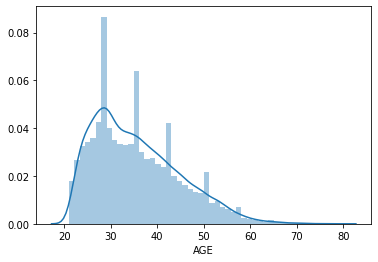

In [58]:
sns.distplot(data['AGE'])
plt.show()

Похоже, что необходимо сделать преобразование, для получения нормального распределения. Применим преобразования Бокса-Кокса с лучшей $\lambda$

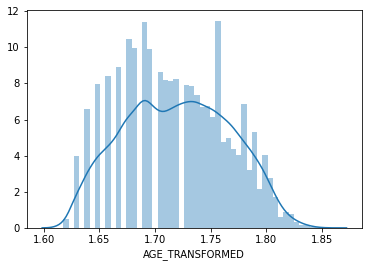

In [59]:
data['AGE_TRANSFORMED'] = scipy.stats.boxcox(data['AGE'])[0]
data.drop(columns='AGE', inplace=True)

sns.distplot(data['AGE_TRANSFORMED'])
plt.show()

Продолжим рассмотрением признака `LIMIT_BAL`:

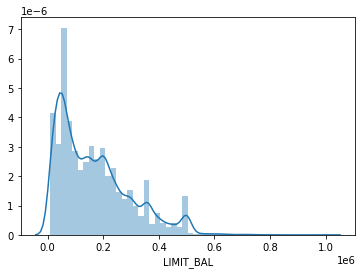

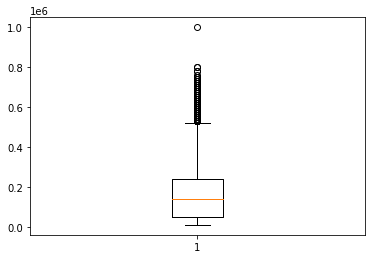

In [60]:
sns.distplot(data['LIMIT_BAL'])
plt.show()
result = plt.boxplot(data['LIMIT_BAL'])
plt.show()

In [61]:
high_data_threshold = result['whiskers'][1].get_data()[1][0]
print(f"{round(100 * (data['LIMIT_BAL'] > high_data_threshold).mean(), 2)}% of data is higher than threshold")

23.56% of data is higher than threshold


Выкидывать 24% выборки мы точно не будем, поэтому лучше сделаем логарифмическое преобразование

In [62]:
data['ln_LIMIT_BAL'] = np.log(data['LIMIT_BAL'])

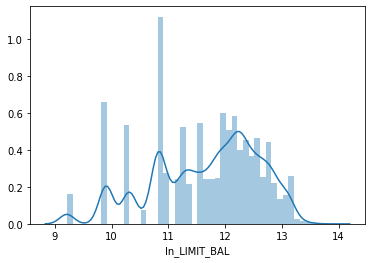

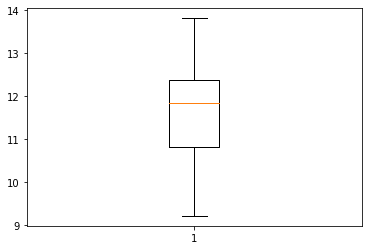

In [63]:
sns.distplot(data['ln_LIMIT_BAL'])
plt.show()
result = plt.boxplot(data['ln_LIMIT_BAL'])
plt.show()

Стало намного лучше - выбросов нет

Посмотрим теперь на признак `PAY_AMT1`:

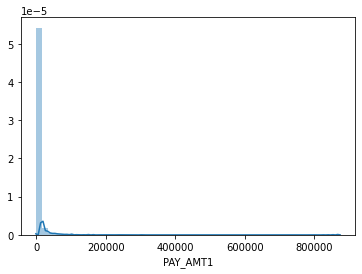

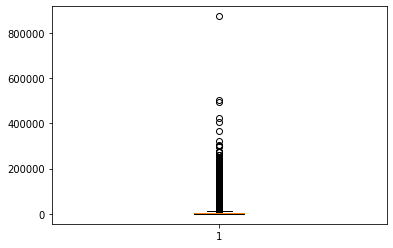

In [64]:
sns.distplot(data['PAY_AMT1'])
plt.show()
result = plt.boxplot(data['PAY_AMT1'])
plt.show()

Видим аналогичную ситуацию, как и с признаком `LIMIT_BAL`. Применим логарифмирование:

In [65]:
data['ln_PAY_AMT1'] = np.log1p(data['PAY_AMT1'])

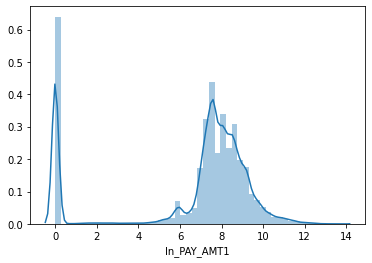

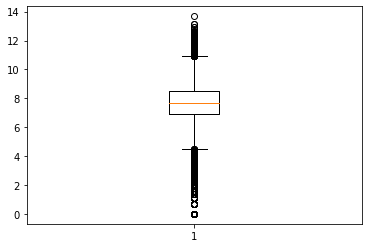

In [66]:
sns.distplot(data['ln_PAY_AMT1'])
plt.show()
result = plt.boxplot(data['ln_PAY_AMT1'])
plt.show()

Кажется необходимо отдельно выделить ситуацию, когда признак равен нулю. Но попробуем другое преобразование - деление на `LIMIT_BAL`:

In [67]:
data['div_PAY_AMT1'] = data['PAY_AMT1'] / data['LIMIT_BAL']

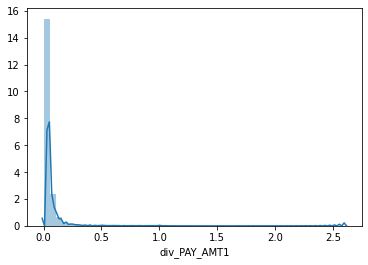

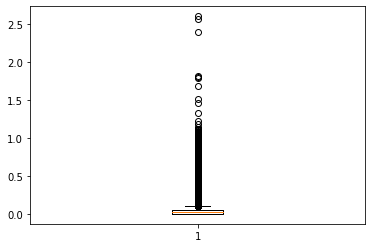

In [68]:
sns.distplot(data['div_PAY_AMT1'])
plt.show()
result = plt.boxplot(data['div_PAY_AMT1'])
plt.show()

Такое преобразование не сработало. Будем работать с логарифмированием:

In [69]:
data['zero_PAY_AMT1'] = (data['PAY_AMT1'] == 0).astype(np.int)

Проделаем аналогичные преобразование для всех признаков вида `PAY_AMT*`:

In [70]:
for col in filter(lambda x: x.startswith('PAY_AMT'), data.columns):
    data[f'ln_{col}'] = np.log1p(data[col])
    data[f'zero_{col}'] = (data[col] == 0).astype(np.int)

In [71]:
data.head()

,LIMIT_BAL,SEX,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,ln_PAY_AMT2,zero_PAY_AMT2,ln_PAY_AMT3,zero_PAY_AMT3,ln_PAY_AMT4,zero_PAY_AMT4,ln_PAY_AMT5,zero_PAY_AMT5,ln_PAY_AMT6,zero_PAY_AMT6
0,20000,1,2,2,-1,-1,-2,-2,3913,3102,...,6.536692,0,0.000000,1,0.000000,1,0.000000,1,0.000000,1
1,120000,1,-1,2,0,0,0,2,2682,1725,...,6.908755,0,6.908755,0,6.908755,0,0.000000,1,7.601402,0
2,90000,1,0,0,0,0,0,0,29239,14027,...,7.313887,0,6.908755,0,6.908755,0,6.908755,0,8.517393,0
3,50000,1,0,0,0,0,0,0,46990,48233,...,7.610853,0,7.090910,0,7.003974,0,6.975414,0,6.908755,0
4,50000,0,-1,0,-1,0,0,0,8617,5670,...,10.510041,0,9.210440,0,9.105091,0,6.536692,0,6.522093,0


## Логистическая регрессия

Обучим в начале логистическую регрессию на всех признаках

In [72]:
X = data.drop(columns=['default payment next month'])
y = data['default payment next month']

In [73]:
model = LogisticRegression(max_iter=1000, penalty='none').fit(X, y)
y_pred = model.predict_proba(X)[:, 1]
print(f"ROC AUC: {roc_auc_score(y, y_pred)}")
print(f"Accuracy: {accuracy_score(y, y_pred >= 0.5)}")         

ROC AUC: 0.7013090048584041
Accuracy: 0.7790666666666667


Попробуем определить какие признаки самые важные:

In [74]:
(model.coef_[0] * X.mean()).abs().sort_values(ascending=False)

LIMIT_BAL          3.683408e-01
BILL_AMT1          3.468144e-01
ln_LIMIT_BAL       3.048142e-01
BILL_AMT2          2.524490e-01
ln_PAY_AMT1        1.529059e-01
ln_PAY_AMT2        1.436018e-01
ln_PAY_AMT3        1.335651e-01
ln_PAY_AMT4        1.195150e-01
ln_PAY_AMT5        1.100777e-01
BILL_AMT3          1.062922e-01
BILL_AMT6          1.051368e-01
ln_PAY_AMT6        1.028794e-01
PAY_AMT1           9.755410e-02
BILL_AMT5          8.142581e-02
PAY_AMT2           6.542062e-02
BILL_AMT4          3.959469e-02
PAY_AMT4           1.996673e-02
PAY_AMT3           1.756240e-02
PAY_AMT5           1.321476e-02
AGE_TRANSFORMED    7.170116e-03
PAY_AMT6           1.760697e-03
SEX                1.095720e-03
MARRIAGE_2         1.038635e-03
PAY_6              9.187023e-04
PAY_5              8.978612e-04
PAY_4              7.919873e-04
PAY_3              6.329570e-04
EDUCATION_2        6.046248e-04
PAY_2              5.771982e-04
MARRIAGE_1         2.047333e-04
EDUCATION_1        1.832290e-04
zero_PAY

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

In [76]:
columns = X.columns
model = LogisticRegression(max_iter=1000, penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.6970113382713672
Accuracy: 0.7804


In [77]:
columns = X.columns
model = LogisticRegression(max_iter=1000, penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.6970113382713672
Accuracy: 0.7804


In [78]:
model = GLM(y, X, family=Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                      
======================================================================================
Dep. Variable:     default payment next month   No. Observations:                30000
Model:                                    GLM   Df Residuals:                    29956
Model Family:                        Binomial   Df Model:                           43
Link Function:                          logit   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:                -13544.
Date:                        Wed, 15 Jul 2020   Deviance:                       27087.
Time:                                04:34:27   Pearson chi2:                 3.40e+04
No. Iterations:                             6                                         
Covariance Type:                    nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
LIMIT_BAL       -1.673e-07   2.93e-07     -0.571      0.568   -7.42e-07    4.07e-07
SEX                -0.0841      0.032     -2.666      0.008      -0.146      -0.022
PAY_0               0.4626      0.018     25.956      0.000       0.428       0.498
PAY_2               0.0513      0.023      2.277      0.023       0.007       0.096
PAY_3               0.0625      0.027      2.282      0.022       0.009       0.116
PAY_4               0.0342      0.030      1.158      0.247      -0.024       0.092
PAY_5               0.0803      0.031      2.581      0.010       0.019       0.141
PAY_6               0.1045      0.025      4.203      0.000       0.056       0.153
BILL_AMT1       -4.287e-06   1.05e-06     -4.072      0.000   -6.35e-06   -2.22e-06
BILL_AMT2         3.75e-06   1.37e-06      2.739      0.006    1.07e-06    6.43e-06
BILL_AMT3         2.15e-06   1.18e-06      1.824      0.068   -1.61e-07    4.46e-06
BILL_AMT4        1.058e-06   1.17e-06      0.905      0.366   -1.23e-06    3.35e-06
BILL_AMT5       -5.959e-07   1.39e-06     -0.428      0.669   -3.33e-06    2.13e-06
BILL_AMT6        9.249e-07   1.11e-06      0.830      0.407   -1.26e-06    3.11e-06
PAY_AMT1         -7.63e-06   2.31e-06     -3.298      0.001   -1.22e-05    -3.1e-06
PAY_AMT2        -1.074e-06    1.5e-06     -0.718      0.473   -4.01e-06    1.86e-06
PAY_AMT3         1.891e-06   1.34e-06      1.408      0.159   -7.41e-07    4.52e-06
PAY_AMT4         3.382e-07   1.64e-06      0.206      0.837   -2.87e-06    3.55e-06
PAY_AMT5        -1.238e-07   1.73e-06     -0.072      0.943   -3.52e-06    3.27e-06
PAY_AMT6         5.293e-07   1.37e-06      0.386      0.699   -2.16e-06    3.22e-06
EDUCATION_1         0.5616      0.678      0.828      0.408      -0.767       1.891
EDUCATION_2         0.5117      0.677      0.756      0.450      -0.815       1.839
EDUCATION_3         0.4886      0.681      0.718      0.473      -0.846       1.823
EDUCATION_4        -0.5144      0.785     -0.655      0.512      -2.053       1.024
EDUCATION_5        -0.7650      0.724     -1.057      0.290      -2.183       0.653
EDUCATION_6         0.2699      0.792      0.341      0.733      -1.282       1.822
MARRIAGE_1          1.1495      0.451      2.550      0.011       0.266       2.033
MARRIAGE_2          0.9524      0.448      2.127      0.033       0.075       1.830
MARRIAGE_3          1.0923      0.471      2.319      0.020       0.169       2.015
AGE_TRANSFORMED     0.6152      0.334      1.840      0.066      -0.040       1.271
ln_LIMIT_BAL       -0.0958      0.038     -2.503      0.012      -0.171      -0.021
ln_PAY_AMT1        -0.1306      0.020     -6.389      0.000      -0.171      -0.091
div_PAY_AMT1        0.8084      0.241      3.357      0

Отберём все признаки с коэффициентами по модулю большими чем 0.1 и низким pvalue:

In [79]:
columns = ['PAY_0', 'PAY_6', 'SEX', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6',
          'AGE_TRANSFORMED', 'ln_LIMIT_BAL', 'ln_PAY_AMT1', 'div_PAY_AMT1', 'PAY_2', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
           'zero_PAY_AMT6', 'zero_PAY_AMT4']
model = LogisticRegression(max_iter=3000, penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.7247434120919698
Accuracy: 0.8086666666666666


Начнём убирать некоторые признаки:

In [80]:
columns = ['PAY_0', 'PAY_6', 'SEX', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6',
           'ln_LIMIT_BAL', 'ln_PAY_AMT1', 'div_PAY_AMT1', 'PAY_2', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
           'zero_PAY_AMT6', 'zero_PAY_AMT4']
model = LogisticRegression(max_iter=1000, penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.7249174007781908
Accuracy: 0.8085333333333333


In [81]:
columns = ['PAY_0', 'PAY_6', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6',
           'ln_LIMIT_BAL', 'ln_PAY_AMT1', 'div_PAY_AMT1', 'PAY_2', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
           'zero_PAY_AMT6', 'zero_PAY_AMT4']
model = LogisticRegression(max_iter=1000, penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.724326887432174
Accuracy: 0.8094666666666667


In [82]:
columns = ['PAY_0', 'PAY_6', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6',
           'ln_LIMIT_BAL', 'ln_PAY_AMT1', 'div_PAY_AMT1', 'PAY_2', 'MARRIAGE_2', 'MARRIAGE_3',
           'zero_PAY_AMT6', 'zero_PAY_AMT4']
model = LogisticRegression(max_iter=1000, penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.7239478276788652
Accuracy: 0.8092


In [83]:
columns = ['PAY_0', 'PAY_6', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
           'ln_LIMIT_BAL', 'ln_PAY_AMT1', 'div_PAY_AMT1', 'PAY_2', 'MARRIAGE_2', 'MARRIAGE_3',
           'zero_PAY_AMT6', 'zero_PAY_AMT4']
model = LogisticRegression(max_iter=1000, penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.7238849883412531
Accuracy: 0.8093333333333333


In [84]:
columns = ['PAY_0', 'PAY_6', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
           'ln_LIMIT_BAL', 'ln_PAY_AMT1', 'div_PAY_AMT1', 'PAY_2', 'MARRIAGE_2', 'MARRIAGE_3', 'zero_PAY_AMT4']
model = LogisticRegression(max_iter=1000, penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.7242726100191745
Accuracy: 0.8090666666666667


In [85]:
columns = ['PAY_0', 'PAY_6', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
           'ln_LIMIT_BAL', 'ln_PAY_AMT1', 'div_PAY_AMT1', 'PAY_2', 'MARRIAGE_2', 'zero_PAY_AMT4']
model = LogisticRegression(max_iter=1000, penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.724337628755779
Accuracy: 0.8092


In [86]:
columns = ['PAY_0', 'PAY_6', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
           'ln_LIMIT_BAL', 'ln_PAY_AMT1', 'PAY_2', 'MARRIAGE_2', 'zero_PAY_AMT4']
model = LogisticRegression(max_iter=1000, penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.7242920689387489
Accuracy: 0.8088


In [87]:
columns = ['PAY_0', 'PAY_6', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3',
           'ln_LIMIT_BAL', 'ln_PAY_AMT1', 'PAY_2', 'MARRIAGE_2', 'zero_PAY_AMT4']
model = LogisticRegression(max_iter=1000, penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.7243960574049543
Accuracy: 0.8088


In [88]:
columns = ['PAY_0', 'PAY_6', 'ln_LIMIT_BAL', 'ln_PAY_AMT1', 'PAY_2', 'zero_PAY_AMT4']
model = LogisticRegression(max_iter=1000, penalty='none').fit(X_train[columns], y_train)
y_pred = model.predict_proba(X_test[columns])[:, 1]
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred >= 0.5)}")   

ROC AUC: 0.7208453494323808
Accuracy: 0.808


Похоже достаточно следующих признаков: `PAY_0`, `PAY_6`, `EDUCATION_1`, `EDUCATION_2`, `EDUCATION_3`, `ln_LIMIT_BAL`, `ln_PAY_AMT1`, `PAY_2`, `MARRIAGE_2`, `zero_PAY_AMT4`

In [89]:
columns = ['PAY_0', 'PAY_6', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3',
           'ln_LIMIT_BAL', 'ln_PAY_AMT1', 'PAY_2', 'MARRIAGE_2', 'zero_PAY_AMT4']
model = GLM(y, X[columns], family=Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                      
======================================================================================
Dep. Variable:     default payment next month   No. Observations:                30000
Model:                                    GLM   Df Residuals:                    29990
Model Family:                        Binomial   Df Model:                            9
Link Function:                          logit   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:                -13765.
Date:                        Wed, 15 Jul 2020   Deviance:                       27530.
Time:                                04:34:39   Pearson chi2:                 3.31e+04
No. Iterations:                             5                                         
Covariance Type:                    nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
PAY_0             0.5199      0.017     29.837      0.000       0.486       0.554
PAY_6             0.1663      0.016     10.326      0.000       0.135       0.198
EDUCATION_1       1.2903      0.148      8.722      0.000       1.000       1.580
EDUCATION_2       1.2419      0.142      8.771      0.000       0.964       1.519
EDUCATION_3       1.2309      0.142      8.667      0.000       0.953       1.509
ln_LIMIT_BAL     -0.1877      0.012    -15.344      0.000      -0.212      -0.164
ln_PAY_AMT1      -0.0660      0.005    -13.732      0.000      -0.075      -0.057
PAY_2             0.0960      0.016      5.934      0.000       0.064       0.128
MARRIAGE_2       -0.2213      0.031     -7.192      0.000      -0.282      -0.161
zero_PAY_AMT4     0.5698      0.039     14.705      0.000       0.494       0.646
=================================================================================
"""

В данном случае у нас получилось достаточно значительно улучшить качество модели, благодаря нашему анализу (ROC-AUC и accuracy поднялись на 2%)